In [1]:
import numpy as np
import pandas as pd
import tushare as ts

# 沪深300指数

In [2]:
HS = ts.get_k_data('hs300',start = '2016-01-04',end='2024-04-29')
HS['Log_Return_ShangZheng'] = np.log(HS['close'] /HS['close'].shift(1))
HS.head()

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


d:\anaconda\envs\py3-9\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
d:\anaconda\envs\py3-9\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
d:\anaconda\envs\py3-9\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
d:\anaconda\envs\py3-9\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, da

,date,open,close,high,low,volume,code,Log_Return_ShangZheng
0,2016-01-04,3725.86,3470.41,3726.24,3469.01,115370674.0,hs300,NaN
1,2016-01-05,3382.18,3478.78,3518.22,3377.28,162116984.0,hs300,0.002409
2,2016-01-06,3482.41,3539.81,3543.74,3468.47,145966144.0,hs300,0.017391
3,2016-01-07,3481.15,3294.38,3481.15,3284.74,44102641.0,hs300,-0.071855
4,2016-01-08,3371.87,3361.56,3418.85,3237.93,185959451.0,hs300,0.020187


# 茅台数据

选用技术特征的原因：由于我们要预测的是股票的收益率，而收益率有正有负，分别表示股票上涨和下跌；股票的技术指标能够很好的捕捉股票的涨跌趋势，因此对于预测股票收益率可以预见能够产生帮助

In [3]:
import tushare as ts
df = ts.get_k_data('600519',start = '2016-01-04',end='2024-04-29')
df.to_csv('stock_daily/600519.csv')
data = pd.read_csv('stock_daily/600519.csv')
del(data['Unnamed: 0'])
del(data['code'])

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


d:\anaconda\envs\py3-9\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
d:\anaconda\envs\py3-9\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
d:\anaconda\envs\py3-9\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
d:\anaconda\envs\py3-9\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, da

In [4]:
data.columns = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume']
data.head()

,Date,Open,Close,High,Low,Volume
0,2016-01-04,54.584,46.604,54.584,46.574,17349.0
1,2016-01-05,46.584,49.404,50.554,44.094,31908.0
2,2016-01-06,49.364,48.764,50.244,45.884,23760.0
3,2016-01-07,45.574,38.814,45.574,36.614,8148.0
4,2016-01-08,40.754,41.214,44.584,36.584,44510.0


In [5]:
df = pd.DataFrame(data)

# 计算移动平均线和指数移动平均线
df['MA10'] = df['Close'].rolling(window=10).mean()
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()

# 计算MACD
df['MACD_Line'] = df['EMA12'] - df['EMA26']
df['Signal_Line'] = df['MACD_Line'].ewm(span=9, adjust=False).mean()
df['MACD_Histogram'] = df['MACD_Line'] - df['Signal_Line']

# 计算RSI
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# 计算Stochastic
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()
df['Stochastic'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))

# 计算OBV
df['OBV'] = 0
df.loc[df['Close'] > df['Close'].shift(1), 'OBV'] = df['Volume']
df.loc[df['Close'] < df['Close'].shift(1), 'OBV'] = -df['Volume']
df['OBV'] = df['OBV'].cumsum()

# 计算Williams %R
lookback_period = 14
df['High_14'] = df['High'].rolling(window=lookback_period).max()
df['Low_14'] = df['Low'].rolling(window=lookback_period).min()
df['Williams_%R'] = -100 * ((df['High_14'] - df['Close']) / (df['High_14'] - df['Low_14']))
del df['High_14']
del df['Low_14']

# 沪深300对数收益率
df['Log_Return_ShangZheng'] = np.log(HS['close'].shift(1) /HS['close'].shift(2))
'''
# 茅台前1天的对数收益率
df['Log_Return_Lag1'] = np.log(df['Close'].shift(1) / df['Close'].shift(2))

# 茅台前2天的对数收益率
df['Log_Return_Lag2'] = np.log(df['Close'].shift(1) / df['Close'].shift(3))

# 茅台前3天的对数收益率
df['Log_Return_Lag3'] = np.log(df['Close'].shift(1) / df['Close'].shift(4))

# 茅台前4天的对数收益率
df['Log_Return_Lag4'] = np.log(df['Close'].shift(1) / df['Close'].shift(5))

# 茅台前5天的对数收益率
df['Log_Return_Lag5'] = np.log(df['Close'].shift(1) / df['Close'].shift(6))

# 茅台前6天的对数收益率
df['Log_Return_Lag6'] = np.log(df['Close'].shift(1) / df['Close'].shift(7))

# 茅台前7天的对数收益率
df['Log_Return_Lag7'] = np.log(df['Close'].shift(1) / df['Close'].shift(8))

# 茅台前14天的对数收益率
df['Log_Return_Lag14'] = np.log(df['Close'].shift(1) / df['Close'].shift(14))
'''
# 计算对数收益率(茅台)
df['Log_Return'] = np.log(df['Open'] / df['Open'].shift(1))

del df["Date"]

# 预测的目标是Log_Return，每一行就是一个样本

In [6]:
df.columns

Index(['Open', 'Close', 'High', 'Low', 'Volume', 'MA10', 'EMA12', 'EMA26',
       'MACD_Line', 'Signal_Line', 'MACD_Histogram', 'RSI', 'Stochastic',
       'OBV', 'Williams_%R', 'Log_Return_ShangZheng', 'Log_Return'],
      dtype='object')

In [7]:
df = df.dropna()
df.head()

,Open,Close,High,Low,Volume,MA10,EMA12,EMA26,MACD_Line,Signal_Line,MACD_Histogram,RSI,Stochastic,OBV,Williams_%R,Log_Return_ShangZheng,Log_Return
13,37.844,36.844,41.174,36.484,21832.0,38.297,40.001201,42.109576,-2.108375,-1.892538,-0.215837,41.686542,21.120498,35498,-78.879502,-0.015237,-0.141218
14,39.694,39.324,39.984,35.394,22733.0,38.108,39.897017,41.903237,-2.006221,-1.915274,-0.090946,44.050343,39.165764,58231,-60.834236,-0.029745,0.047728
15,39.584,39.354,40.074,38.084,13750.0,38.399,39.813476,41.714405,-1.900929,-1.912405,0.011476,41.397021,40.000000,71981,-60.000000,0.010367,-0.002775
16,37.574,35.594,41.054,35.084,22280.0,38.621,39.164325,41.261042,-2.096716,-1.949267,-0.147449,39.297903,23.616734,49701,-76.383266,0.004944,-0.052113
17,36.564,36.514,37.474,32.284,29840.0,38.636,38.756583,40.909409,-2.152826,-1.989979,-0.162847,47.809524,29.824561,79541,-70.175439,-0.062095,-0.027248


In [8]:
# 划分训练集和测试集
# 计算各个切分点
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size   # 确保全部数据被合理分配

train_data = df[:train_size]
train_data.to_csv('./stock_daily/stock_train.csv',header = False, index=False)
train_data = pd.read_csv('./stock_daily/stock_train.csv')

test_data = df[train_size:]
test_data.to_csv('./stock_daily/stock_test.csv',header = False, index=False)
test_data = pd.read_csv('./stock_daily/stock_test.csv')

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import Dataset,DataLoader

In [76]:
TRAIN_WEIGHT=0.9
SEQ_LEN=59
LEARNING_RATE=0.00001
BATCH_SIZE=32

mean_list=[]
std_list=[]

In [77]:
#完成数据集类
class Stock_Data(Dataset):
    def __init__(self,train=True,transform=None):        
        if train==True:
            train_path="stock_daily/stock_train.csv"
            with open(train_path) as f:
                self.data = np.loadtxt(f,delimiter = ",")
                num_cols = self.data.shape[1]
                #可以注释
                #addi=np.zeros((self.data.shape[0],1))
                #self.data=np.concatenate((self.data,addi),axis=1)
                self.data=self.data[:,0:num_cols]
                
            # 对每一个特征进行归一化，类似BatchNorm
            # 不对target进行归一化，方便后面和ARMA得到的结果进行对比
            for i in range(len(self.data[0])-1):
                mean_list.append(np.mean(self.data[:,i]))
                std_list.append(np.std(self.data[:,i]))
                self.data[:,i]=(self.data[:,i]-np.mean(self.data[:,i]))/(np.std(self.data[:,i])+1e-8)
            self.value=torch.rand(self.data.shape[0]-SEQ_LEN, SEQ_LEN, self.data.shape[1])
            self.label=torch.rand(self.data.shape[0]-SEQ_LEN,1)
            for i in range(self.data.shape[0]-SEQ_LEN):                  
                self.value[i,:,:]=torch.from_numpy(self.data[i:i+SEQ_LEN,:].reshape(SEQ_LEN,self.data.shape[1]))    
                self.label[i,:]=self.data[i+SEQ_LEN,-1]
            self.data=self.value
        else:
            test_path="stock_daily/stock_test.csv"
            with open(test_path) as f:
                self.data = np.loadtxt(f,delimiter = ",")
                #addi=np.zeros((self.data.shape[0],1))
                #self.data=np.concatenate((self.data,addi),axis=1)
                num_cols = self.data.shape[1]
                self.data=self.data[:,0:num_cols]
            for i in range(len(self.data[0])-1):
                self.data[:,i]=(self.data[:,i]-mean_list[i])/(std_list[i]+1e-8)
            self.value=torch.rand(self.data.shape[0]-SEQ_LEN,SEQ_LEN,self.data.shape[1])
            self.label=torch.rand(self.data.shape[0]-SEQ_LEN,1)
            for i in range(self.data.shape[0]-SEQ_LEN):                  
                self.value[i,:,:]=torch.from_numpy(self.data[i:i+SEQ_LEN,:].reshape(SEQ_LEN,self.data.shape[1]))    
                self.label[i,:]=self.data[i+SEQ_LEN,-1]
            self.data=self.value
    def __getitem__(self,index):
        return self.data[index],self.label[index]
    def __len__(self):
        return len(self.data[:,0])

In [78]:
stock_train=Stock_Data(train=True)
stock_test=Stock_Data(train=False)

In [79]:
stock_train.__getitem__(0)

(tensor([[-1.3681e+00, -1.3712e+00, -1.3663e+00,  ..., -1.3118e+00,
          -1.2659e+00, -1.4122e-01],
         [-1.3653e+00, -1.3675e+00, -1.3681e+00,  ..., -6.7867e-01,
          -2.4593e+00,  4.7728e-02],
         [-1.3654e+00, -1.3674e+00, -1.3680e+00,  ..., -6.4940e-01,
           8.4040e-01, -2.7750e-03],
         ...,
         [-1.3049e+00, -1.3052e+00, -1.3042e+00,  ..., -1.4863e+00,
          -1.0337e-01,  2.0176e-03],
         [-1.3022e+00, -1.3060e+00, -1.3055e+00,  ..., -1.5920e+00,
          -1.1200e+00,  2.2298e-02],
         [-1.3043e+00, -1.3132e+00, -1.3066e+00,  ..., -1.6279e+00,
           2.3819e-01, -1.7397e-02]]),
 tensor([-0.0343]))

In [80]:
stock_train.__getitem__(1)

(tensor([[-1.3653, -1.3675, -1.3681,  ..., -0.6787, -2.4593,  0.0477],
         [-1.3654, -1.3674, -1.3680,  ..., -0.6494,  0.8404, -0.0028],
         [-1.3685, -1.3731, -1.3665,  ..., -1.2242,  0.3943, -0.0521],
         ...,
         [-1.3022, -1.3060, -1.3055,  ..., -1.5920, -1.1200,  0.0223],
         [-1.3043, -1.3132, -1.3066,  ..., -1.6279,  0.2382, -0.0174],
         [-1.3084, -1.3103, -1.3098,  ..., -1.3173, -1.4803, -0.0343]]),
 tensor([0.0065]))

In [81]:
stock_train.data.shape

torch.Size([1548, 59, 17])

In [82]:
class LSTM(nn.Module):
    def __init__(self,dimension):
        super(LSTM,self).__init__()
        self.lstm=nn.LSTM(input_size=dimension,hidden_size=128,num_layers=3,batch_first=True)
        self.linear1=nn.Linear(in_features=128,out_features=16)
        self.linear2=nn.Linear(16,1)
    def forward(self,x):
        out,_=self.lstm(x)
        x=out[:,-1,:]        
        x=self.linear1(x)
        x=self.linear2(x)
        return x


In [83]:
#x维度实例化模型
model=LSTM(dimension=17)
model=model.to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [84]:
def train(epoch):    
    model.train()
    global loss_list
    global iteration
    dataloader=DataLoader(dataset=stock_train,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
    for i,(data,label) in enumerate(dataloader):
        iteration=iteration+1
        data,label = data.to(device),label.to(device)
        optimizer.zero_grad()
        output=model.forward(data)
        loss=criterion(output,label)
        loss.backward()        
        optimizer.step()
        if i%20==0:
            loss_list.append(loss.item())
            print("epoch=",epoch,"iteration=",iteration,"loss=",loss.item())

In [85]:
def test():
    model.eval()
    global accuracy_list
    global predict_list
    dataloader=DataLoader(dataset=stock_test,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
    for i,(data,label) in enumerate(dataloader):
        with torch.no_grad():            
            data,label=data.to(device),label.to(device)
            optimizer.zero_grad()
            predict=model.forward(data)
            predict_list.append(predict)
            loss=criterion(predict,label)
            accuracy_fn=nn.MSELoss()
            accuracy=accuracy_fn(predict,label)
            accuracy_list.append(accuracy.item())
    print("test_data MSELoss:(pred-real)/real=",np.mean(accuracy_list))

In [86]:
def loss_curve(loss_list):
    x=np.linspace(1,len(loss_list),len(loss_list))
    x=20*x
    plt.plot(x,np.array(loss_list),label="train_loss")
    plt.ylabel("MSELoss")
    plt.xlabel("iteration")
    plt.savefig("train_loss.png",dpi=3000)
    plt.show()

In [87]:
def contrast_lines(predict_list):
    real_list = []
    prediction_list = []
    dataloader = DataLoader(dataset=stock_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    
    for i, (data, label) in enumerate(dataloader):
        for idx in range(BATCH_SIZE):
            real_list.append(label[idx].numpy())
    
    for item in predict_list:
        item = item.to("cpu")
        for idx in range(BATCH_SIZE):
            prediction_list.append(item[idx].numpy())

    x = np.linspace(1, len(real_list), len(real_list))
    plt.plot(x, np.array(real_list), label="real")
    plt.plot(x, np.array(prediction_list), label="prediction")
    plt.legend()
    plt.savefig("_Pre.png", dpi=3000)
    plt.show()


epoch= 0 iteration= 1 loss= 0.02113965153694153
epoch= 0 iteration= 21 loss= 0.015373941510915756
epoch= 0 iteration= 41 loss= 0.013057139702141285
test_data MSELoss:(pred-real)/real= 0.011569725535809993
epoch= 1 iteration= 49 loss= 0.016048520803451538
epoch= 1 iteration= 69 loss= 0.011373456567525864
epoch= 1 iteration= 89 loss= 0.009407861158251762
test_data MSELoss:(pred-real)/real= 0.008065866911783815
epoch= 2 iteration= 97 loss= 0.012201040983200073
epoch= 2 iteration= 117 loss= 0.008114608004689217
epoch= 2 iteration= 137 loss= 0.006519700400531292
test_data MSELoss:(pred-real)/real= 0.005277191521599889
epoch= 3 iteration= 145 loss= 0.00901227816939354
epoch= 3 iteration= 165 loss= 0.005489971023052931
epoch= 3 iteration= 185 loss= 0.004299866035580635
test_data MSELoss:(pred-real)/real= 0.003147901641204953
epoch= 4 iteration= 193 loss= 0.006461625453084707
epoch= 4 iteration= 213 loss= 0.003490170929580927
epoch= 4 iteration= 233 loss= 0.002727250102907419
test_data MSELoss

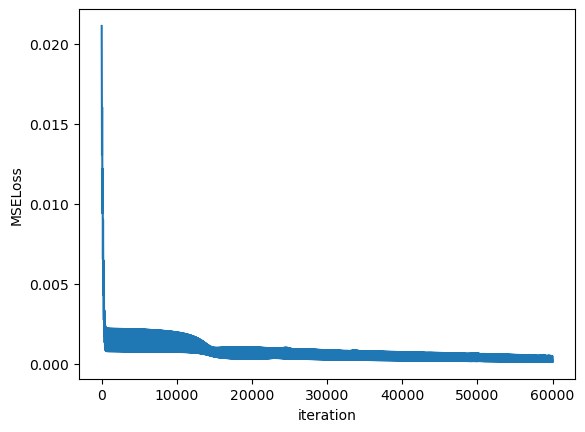

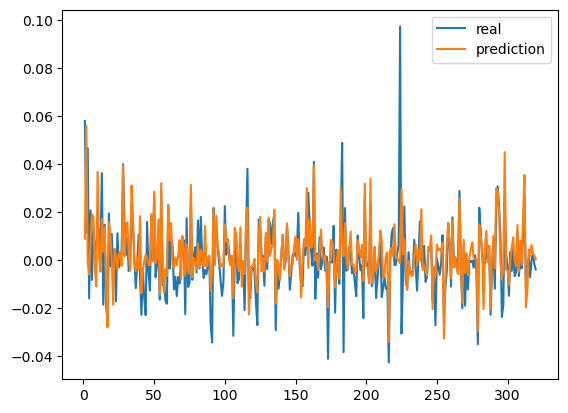

In [88]:
import matplotlib.pyplot as plt
if __name__=="__main__":   
    period = 100
    iteration=0
    loss_list=[]
    #开始训练神经网络
    for epoch in range(1000):         
        predict_list=[]
        accuracy_list=[]
        train(epoch)
        test()
    #绘制损失函数下降曲线    
    loss_curve(loss_list)
    #绘制测试集pred-real对比曲线
    contrast_lines(predict_list)